In [66]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict ,Annotated,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator
import os

In [67]:
load_dotenv()
model = ChatOpenAI(model=os.getenv("MODEL_NAME"))

In [68]:
positive_review = "I really enjoyed using this product. It exceeded my expectations and I am extremely satisfied with my purchase."
negative_review = "There is an urgent performance bug in this product that needs immediate fixing."

In [69]:
class SentimentSchema(BaseModel):
    sentiment:Literal["positive","negative"] = Field(description="is this review positive or negative")

sentiment_model = model.with_structured_output(SentimentSchema)
# print(sentiment_model.invoke(positive_review).sentiment)
# print(sentiment_model.invoke(negative_review).sentiment)

In [70]:
class NegativeReviewBreakdown(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

negative_review_breakdown_model = model.with_structured_output(NegativeReviewBreakdown)

In [71]:
class CustomerReviewState(TypedDict):
    review: str
    sentiment: Literal["positive","negative"]
    diagnosis: dict
    negative_review_reply: str
    positive_review_reply: str

In [72]:
def find_sentiment(state:CustomerReviewState)->CustomerReviewState:
    sentiment = sentiment_model.invoke(state["review"]).sentiment
    return {"sentiment":sentiment}

In [73]:
def run_diagnosis(state: CustomerReviewState) -> CustomerReviewState:
    diagnosis = negative_review_breakdown_model.invoke(state["review"])
    return {
        "diagnosis": diagnosis.model_dump()
    }

In [74]:
def generate_negative_reply(state:CustomerReviewState)->CustomerReviewState:
    prompt = f"""
    The customer has given a negative review.
    The review is as follows:
    {state["review"]}
    The breakdown of the review is as follows:
    {state["diagnosis"]}
    
    Now you need to reply to customer and tell them that you are sorry for the inconvenience.
    """
    reply = model.invoke(prompt).content
    return {"negative_review_reply":reply}


In [75]:
def generate_positive_reply(state:CustomerReviewState)->CustomerReviewState:
    prompt = f"""
    The customer has given a positive review.
    The review is as follows:
    {state["review"]}
    
    Now you need to reply to customer and thank them for their review.
    """
    reply = model.invoke(prompt).content
    return {"positive_review_reply":reply}

In [76]:
def check_sentiment(state:CustomerReviewState)->Literal["generate_positive_reply","run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "generate_positive_reply"
    else:
        return "run_diagnosis"
    

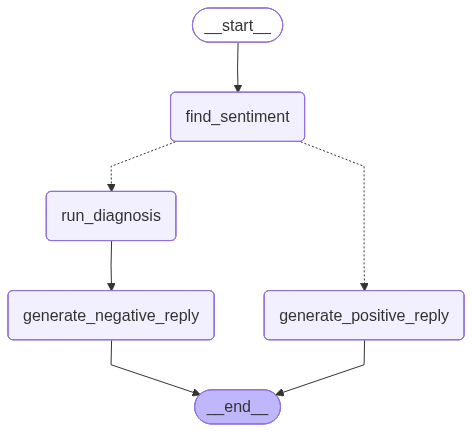

In [77]:
graph = StateGraph(CustomerReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("generate_negative_reply", generate_negative_reply)
graph.add_node("generate_positive_reply", generate_positive_reply)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges(
    "find_sentiment",
    check_sentiment,
    # {
    #     "positive_response": "generate_positive_reply",
    #     "run_diagnosis": "run_diagnosis"
    # }
)
graph.add_edge("run_diagnosis", "generate_negative_reply")
graph.add_edge("generate_negative_reply", END)
graph.add_edge("generate_positive_reply", END)

workflow = graph.compile()
workflow

In [78]:
# init_state = {"review":positive_review}
# workflow.invoke({"review":positive_review})

In [ ]:
init_state = {"review":negative_review}
workflow.invoke(init_state)